# Exploration

Dans cette partie on va donc explorer nos données afin de se familiariser avec le dataset.

Pour cette exploration j'utilise une variable `version` qui me permet d'avoir le même résultat par rapport à la version du script que je souhaite utiliser.

En interne certaines actions sont effectuées sur le dataset suivant la version. Cela me permet de montrer ma démarche et la progression des traitements / explorations du dataset.

In [113]:
%load_ext autoreload
%autoreload 2
from src.dataset import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use(['ggplot', 'https://raw.githubusercontent.com/AlanBlanchet/matplotlib_styles/master/vscode_blue.mplstyle'])

Dataset.init()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


src.dataset.dataset.Dataset

On peut faire une cellule de comparaison pour avoir un affichage des données brutes et des données traitées

In [3]:
Dataset.example("topics1.csv", random_state=0, version=1)

Original ============================================
 I have devise authentication and registration set up on my Rails app. I'm using   to customise the redirect when the user signs in based on various scenarios. 
 What I'm asking is how to test this method? It seems hard to isolate since it is called automatically by Devise when the user signes in. I want to do something like this: 
 
 but that's obviously not the way to do it because I just get an error: 
 
 So, how can I test this method? 

Parsed ==============================================
 devis authent registr set rail app m use customis redirect user sign base variou scenario m ask test method seem hard isol sinc call automat devis user sign want someth like s obvious way get error test method


Regardons les mots les plus communs et identifions les mots inutiles

In [7]:
freq = Dataset.most_common("commons_v0", version=1)
freq.most_common(20)

100%|██████████| 50000/50000 [00:01<00:00, 26925.30it/s]


[('.', 241604),
 (',', 206128),
 (':', 105975),
 (')', 68733),
 ('?', 68077),
 ('(', 66522),
 ('use', 63834),
 ("n't", 30743),
 ("'m", 27809),
 ('like', 26864),
 ('work', 26846),
 ('code', 26309),
 ('tri', 25970),
 ("'s", 25740),
 ('get', 24747),
 ('file', 22418),
 ("''", 21010),
 ('would', 20275),
 ('``', 20155),
 ('want', 18073)]

On remarque dors et déjà qu'on a des ponctuations.

J'ai bien envie de faire un système pour pouvoir voir les phrases en brute et les voir en preprocessé pour voir la différence et comprendre certains cas. On peut donc retirer ces ponctuations puis regarder quelques examples qui nous permettrons d'avancer.

In [10]:
freq = Dataset.most_common("commons_v0", version=2)
freq.most_common(20)

100%|██████████| 50000/50000 [00:01<00:00, 29378.56it/s]


[('thi', 68513),
 ('use', 62186),
 ('n', 32215),
 ('t', 31421),
 ('m', 28153),
 ('like', 26856),
 ('code', 26733),
 ('tri', 25153),
 ('get', 24847),
 ('work', 23945),
 ('file', 21107),
 ('ani', 20344),
 ('would', 20285),
 ('want', 18020),
 ('way', 17129),
 ('one', 16007),
 ('error', 15792),
 ('need', 15097),
 ('run', 14975),
 ('problem', 13729)]

On remarque déjà qu'il y a le "n't" qui correspond à une négation.

Il y a également des mots qu'on aimerait certainement exclure car il n'apporte par de plus value pour nos prédictions de tags comme par exemple : "problem", "error", "get", "code", "like"...

Pour régler le problème de la négation, je me suis d'abord dit qu'il serait bien de supprimer les chaînes qui ont une longueur égale à 1. Mais rappelons un instant que le langage C comporte 1 seul caractère. Il n'est donc pas possible de procéder comme cela. On aimerait possiblement conserver la négation car cela pourrait être utile pour une phrase du genre : "this is not Java". On gardera dans un premier temps cette négation.

Pour les mots qu'on aimerait exclure, je propose de mettre ces mots dans un fichier texte. Ils feront office de "stopwords" propres au projet. (dans data/exclude.txt)

In [ ]:
Dataset.example("topics1.csv", random_state=0, version=1, interactive=True, index=1)

--------------- index=3
Original ============================================
 How can hibernate can access a private field/method of a java class , for example to set the @Id ? 
 Thanks 

Parsed ==============================================
 hibern access privat field/method java class , exampl set @ id ? thank
Targets ========== java;hibernate;reflection;field;private
None


On a donc tous les outils en main pour commencer à effectuer des analyses plus poussées et effectuer des tests sur nos données.

In [34]:
df = Dataset.use("topics1.csv", version=0)
df.head()

,title,text,target
0,Emacs ido-style shell,<p>Is there a command line shell or shell cust...,bash;shell;emacs;eshell;ido
1,Include Google Maps API Key in open source pro...,<p>Is it okay to put your Google Maps API Key ...,security;api;open-source;google-maps;publish
2,How do I do large non-blocking updates in Post...,<p>I want to do a large update on a table in P...,postgresql;transactions;sql-update;plpgsql;dblink
3,How can hibernate access a private field?,<p>How can hibernate can access a private fiel...,java;hibernate;reflection;field;private
4,How to add NSViewController to a responder chain?,<p>I'm having hard time understanding and find...,objective-c;macos;cocoa;nsviewcontroller;nsres...


count    50000.000000
mean      1683.321440
std       2098.184664
min         21.000000
5%         250.000000
10%        353.000000
25%        607.000000
50%       1077.000000
75%       1955.000000
90%       3485.000000
95%       4986.000000
97.5%     6992.000000
max      48656.000000
Name: text, dtype: float64

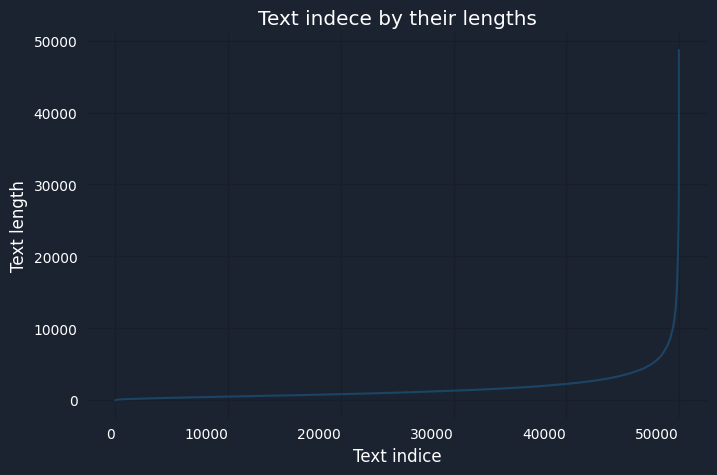

In [143]:
sententences_l = df.text.str.len().sort_values()
plt.figure(figsize=(8,5))
plt.title("Text indece by their lengths")
plt.xlabel("Text indice")
plt.ylabel("Text length")
sententences_l.reset_index(drop=True).plot()
sententences_l.describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975])

On remarque que quelques phrases sont très longues (2.5% avec l > 6992)

In [68]:
target_list = df.target.str.split("|").explode()
print(len(target_list.unique()))

18467


In [76]:
target_list_counts = target_list.value_counts().sort_values()
target_list_count_under_5 = target_list_counts[target_list_counts < 5]
target_list_count_under_5

target
google-api-nodejs-client    1
luxon                       1
empty-list                  1
google-cloud-armor          1
boost-tuples                1
                           ..
sqlgeography                4
code-golf                   4
temporary-objects           4
database-agnostic           4
bower-install               4
Name: count, Length: 13097, dtype: int64

Certains targets ne seront certainement pas simple à trouver car seulement 5000 ont une fréquence de 5 ou +. On peut donc se demander si conserver autant d'éléments est utile. On verra par la suite ce que l'on fait

count
5    32593
4    13319
3     3381
2      627
1       68
0       12
Name: count, dtype: int64

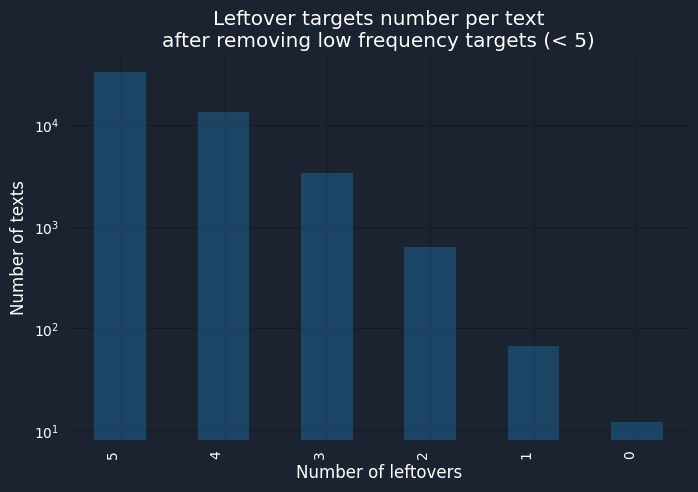

In [154]:
target_list_over_5 = target_list[~target_list.isin(target_list_count_under_5.index)]
target_list_over_5_target_count = pd.Series(target_list_over_5.index.value_counts()).value_counts()
target_list_over_5_target_count[0] = len(df) - target_list_over_5_target_count.sum()
plt.figure(figsize=(8,5))
plt.title("Leftover targets number per text\nafter removing low frequency targets (< 5)")
plt.yscale('log')
target_list_over_5_target_count.plot(kind="bar")
plt.xlabel("Number of leftovers")
plt.ylabel("Number of texts")
target_list_over_5_target_count

De plus, si on retirait ces targets, 12 lignes n'auraient plus de target du tout.